In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression


In [18]:
bvas = pd.read_csv("../sandbox/BVAS_Ranked_Mutations.tsv", sep="\t")
bvas.rename(columns={"Run date": "Run_Date",
                     "Rank": "Rank_BVAS",
                     "PIP": "PIP_BVAS",
                     "Beta": "Beta_BVAS"},
                inplace=True)
bvas["Site"] = bvas["Unnamed: 0"].apply(lambda z: z.split(':')[0])
bvas["Mutation"] = bvas["Unnamed: 0"].apply(lambda z: z.split(':')[1])


bvas = bvas[["Run_Date", "Site", "Mutation", "PIP_BVAS", "Beta_BVAS", "Rank_BVAS"]]
bvas["Run_Date"] = pd.to_datetime(bvas["Run_Date"])
bvas

Run_Date   Site Mutation  PIP_BVAS  Beta_BVAS  Rank_BVAS
0      2021-03-12      S    L452R  1.000000   0.391635          1
1      2021-03-12      S    R346T  1.000000   0.595724          2
2      2021-03-12      S    R346K  1.000000   0.351070          3
3      2021-03-12      S    L452Q  1.000000   0.483694          4
4      2021-03-12      S    L452M  1.000000   0.462981          5
...           ...    ...      ...       ...        ...        ...
143183 2024-01-04  ORF10     L37F  0.003658   0.000000       3788
143184 2024-01-04   ORF8     S24L  0.003557   0.000000       3789
143185 2024-01-04  ORF1a   L3829F  0.002865  -0.000081       3790
143186 2024-01-04  ORF1a    T265I  0.002416  -0.000020       3791
143187 2024-01-04  ORF3a     Q57H  0.002218   0.000000       3792

[143188 rows x 6 columns]

In [19]:
pyro = pd.read_csv("../sandbox/PyR0_Ranked_Mutations.tsv", sep="\t")
pyro.rename(columns={"Δ log R": "LogR_Pyro",
                     "R / R_A": "Growth_Pyro",
                     "Run date": "Run_Date"},
            inplace=True)

pyro["Site"] = pyro["mutation"].apply(lambda z: z.split(':')[0])
pyro["Mutation"] = pyro["mutation"].apply(lambda z: z.split(':')[1])

pyro = pyro[["Run_Date", "Site", "Mutation", "LogR_Pyro", "Growth_Pyro"]]
pyro["Run_Date"] = pd.to_datetime(pyro["Run_Date"])
pyro["Rank_Pyro"] = pyro.groupby(["Run_Date"])["Growth_Pyro"].rank(ascending=False)
pyro

Run_Date   Site Mutation  LogR_Pyro  Growth_Pyro  Rank_Pyro
0      2021-03-12      S    R346K   0.094890     1.099540       27.0
1      2021-03-12      M      D3N   0.120831     1.128430       15.0
2      2021-03-12      S    F486V   0.116173     1.123190       16.0
3      2021-03-12      S    L452Q   0.095844     1.100590       25.0
4      2021-03-12  ORF9b     D16G   0.100566     1.105800       23.0
...           ...    ...      ...        ...          ...        ...
156885 2024-01-04  ORF1a   I2230T  -0.006789     0.993234     3624.0
156886 2024-01-04      S    A570D  -0.006844     0.993179     3628.0
156887 2024-01-04  ORF1a   A1708D  -0.006912     0.993112     3634.0
156888 2024-01-04  ORF1a   T1001I  -0.006956     0.993068     3636.0
156889 2024-01-04  ORF1b   T1050N  -0.045441     0.955576     3791.0

[156890 rows x 6 columns]

In [20]:
bvas_top = list(bvas[bvas["Rank_BVAS"]<=5]["Mutation"].unique())
pyro_top = list(pyro[pyro["Rank_Pyro"]<=5]["Mutation"].unique())
hits = [x for x in bvas_top if x in pyro_top]
hits

['R346T', 'L452M', 'F486P']

In [21]:
combined = pyro.merge(bvas, on=["Run_Date", "Site", "Mutation"], how="inner")
combined["Hits"] = combined["Mutation"].apply(lambda z: 1 if z in hits else 0)
combined["Site"] = pd.Categorical(combined["Site"], categories = ['S','N','M','E','ORF1a','ORF1b','ORF3a','ORF6','ORF7a','ORF7b','ORF8','ORF9b','ORF10','ORF14'], ordered = True)

# set up colour dictionary
strain_correspondence = combined[["Site", "Mutation"]].drop_duplicates()
mut_site = dict(zip(strain_correspondence["Mutation"], strain_correspondence["Site"]))
site_palette = dict(zip(combined["Site"].sort_values().unique(), sns.color_palette("husl",len(combined["Site"].unique())).as_hex()))
mut_palette = {key_A: site_palette[value_B] for key_A, value_B in mut_site.items() if value_B in site_palette}
combined


Run_Date   Site Mutation  LogR_Pyro  Growth_Pyro  Rank_Pyro  \
0      2021-03-12      S    R346K   0.094890     1.099540       27.0   
1      2021-03-12      M      D3N   0.120831     1.128430       15.0   
2      2021-03-12      S    F486V   0.116173     1.123190       16.0   
3      2021-03-12      S    L452Q   0.095844     1.100590       25.0   
4      2021-03-12  ORF9b     D16G   0.100566     1.105800       23.0   
...           ...    ...      ...        ...          ...        ...   
142909 2024-01-04  ORF1a   I2230T  -0.006789     0.993234     3624.0   
142910 2024-01-04      S    A570D  -0.006844     0.993179     3628.0   
142911 2024-01-04  ORF1a   A1708D  -0.006912     0.993112     3634.0   
142912 2024-01-04  ORF1a   T1001I  -0.006956     0.993068     3636.0   
142913 2024-01-04  ORF1b   T1050N  -0.045441     0.955576     3791.0   

        PIP_BVAS  Beta_BVAS  Rank_BVAS  Hits  
0       1.000000   0.351070          3     0  
1       0.312582   0.058252        101     0  
2       1.000000   0.516438          8     0  
3       1.000000   0.483694          4     0  
4       1.000000   0.146039         10     0  
...          ...        ...        ...   ...  
142909  0.092005   0.015395        228     0  
142910  0.138075   0.025655        197     0  
142911  0.105704   0.021116        217     0  
142912  0.033894   0.004340        393     0  
142913  0.901093   0.059471         75     0  

[142914 rows x 10 columns]

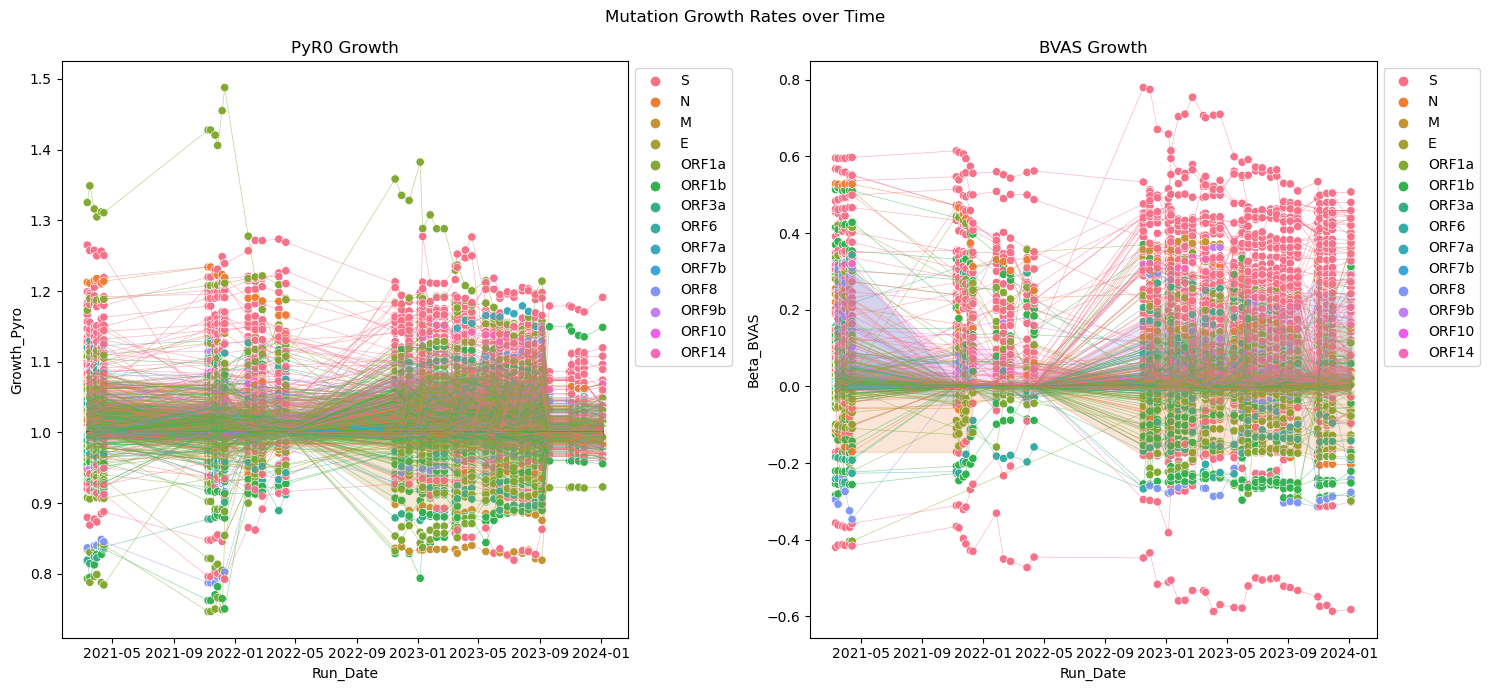

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.scatterplot(data=combined,
                x="Run_Date",
                y="Growth_Pyro",
                hue="Site",
                palette=site_palette,
                ax=ax[0])
sns.lineplot(data=combined,
                x="Run_Date",
                y="Growth_Pyro",
                hue="Mutation",
                palette=mut_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[0])
#ax[0].set_ylim([max(combined["Rank_Pyro"]), -50])
ax[0].set_title("PyR0 Growth")
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))


sns.scatterplot(data=combined,
                x="Run_Date",
                y="Beta_BVAS",
                hue="Site",
                palette=site_palette,
                ax=ax[1])
sns.lineplot(data=combined,
                x="Run_Date",
                y="Beta_BVAS",
                hue="Mutation",
                palette=mut_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[1])
#ax[1].set_ylim([max(combined["Rank_BVAS"]), -50])
ax[1].set_title("BVAS Growth")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.suptitle("Mutation Growth Rates over Time")
plt.tight_layout()

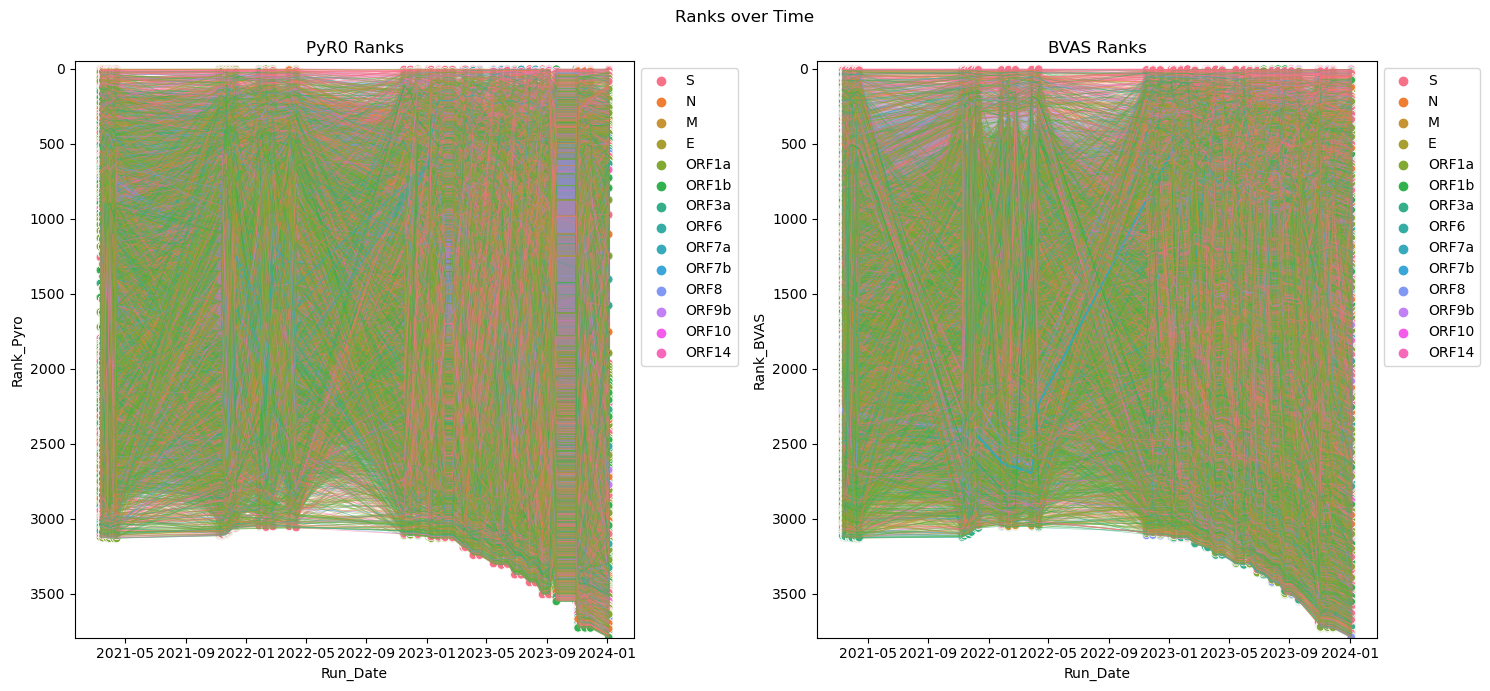

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.scatterplot(data=combined,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Site",
                palette=site_palette,
                ax=ax[0])
sns.lineplot(data=combined,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Mutation",
                palette=mut_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[0])
ax[0].set_ylim([max(combined["Rank_Pyro"]), -50])
ax[0].set_title("PyR0 Ranks")
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))


sns.scatterplot(data=combined,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Site",
                palette=site_palette,
                ax=ax[1])
sns.lineplot(data=combined,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Mutation",
                palette=mut_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[1])
ax[1].set_ylim([max(combined["Rank_BVAS"]), -50])
ax[1].set_title("BVAS Ranks")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.suptitle("Ranks over Time")
plt.tight_layout()

In [24]:
combined

Run_Date   Site Mutation  LogR_Pyro  Growth_Pyro  Rank_Pyro  \
0      2021-03-12      S    R346K   0.094890     1.099540       27.0   
1      2021-03-12      M      D3N   0.120831     1.128430       15.0   
2      2021-03-12      S    F486V   0.116173     1.123190       16.0   
3      2021-03-12      S    L452Q   0.095844     1.100590       25.0   
4      2021-03-12  ORF9b     D16G   0.100566     1.105800       23.0   
...           ...    ...      ...        ...          ...        ...   
142909 2024-01-04  ORF1a   I2230T  -0.006789     0.993234     3624.0   
142910 2024-01-04      S    A570D  -0.006844     0.993179     3628.0   
142911 2024-01-04  ORF1a   A1708D  -0.006912     0.993112     3634.0   
142912 2024-01-04  ORF1a   T1001I  -0.006956     0.993068     3636.0   
142913 2024-01-04  ORF1b   T1050N  -0.045441     0.955576     3791.0   

        PIP_BVAS  Beta_BVAS  Rank_BVAS  Hits  
0       1.000000   0.351070          3     0  
1       0.312582   0.058252        101     0  
2       1.000000   0.516438          8     0  
3       1.000000   0.483694          4     0  
4       1.000000   0.146039         10     0  
...          ...        ...        ...   ...  
142909  0.092005   0.015395        228     0  
142910  0.138075   0.025655        197     0  
142911  0.105704   0.021116        217     0  
142912  0.033894   0.004340        393     0  
142913  0.901093   0.059471         75     0  

[142914 rows x 10 columns]

In [25]:
combined["AvgRank_Pyro"] = combined.groupby(["Site", "Run_Date"])["Rank_Pyro"].transform("mean")
combined["MaxRank_Pyro"] = combined.groupby(["Site", "Run_Date"])["Rank_Pyro"].transform("min")

combined["AvgRank_BVAS"] = combined.groupby(["Site", "Run_Date"])["Rank_BVAS"].transform("mean")
combined["MaxRank_BVAS"] = combined.groupby(["Site", "Run_Date"])["Rank_BVAS"].transform("min")

combined_reduced = combined[["Run_Date", "Site", "AvgRank_Pyro", "MaxRank_Pyro", "AvgRank_BVAS", "MaxRank_BVAS"]].drop_duplicates().reset_index(drop=True)

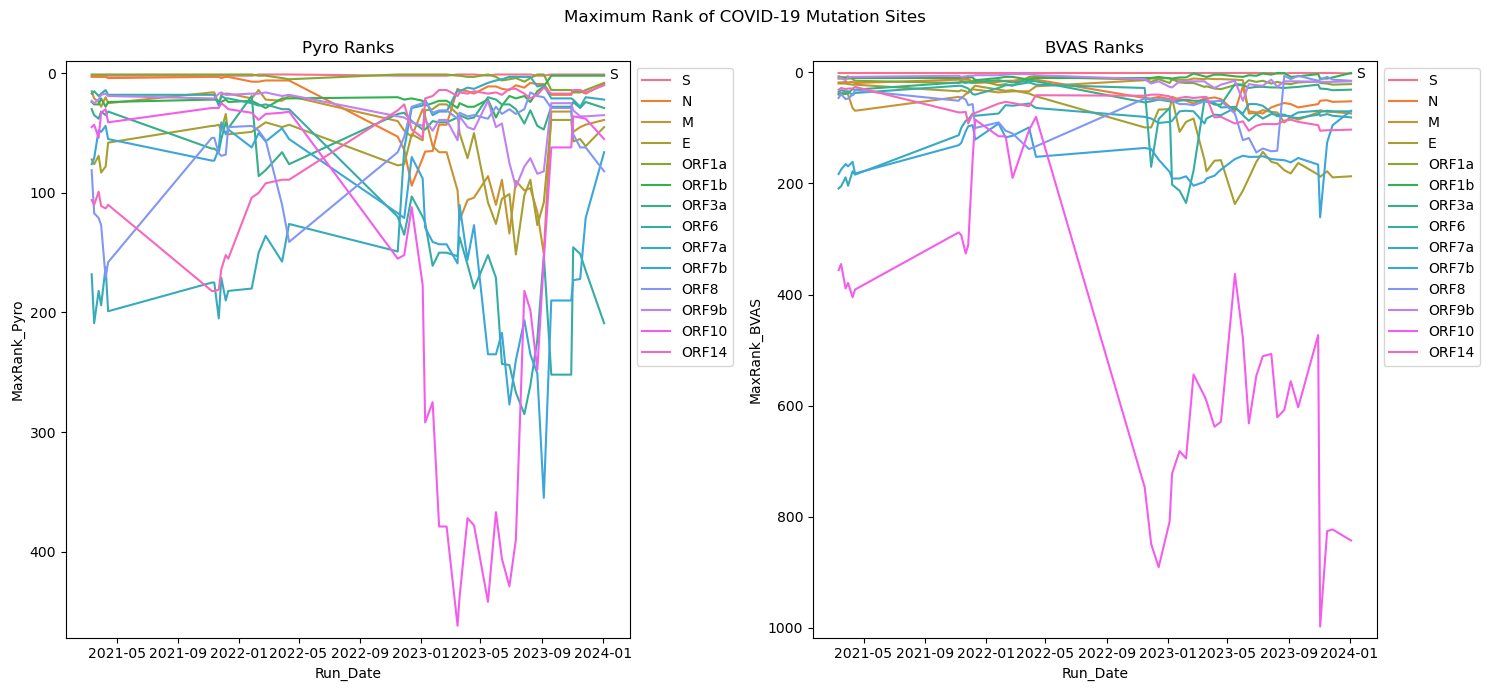

In [31]:

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.lineplot(data = combined_reduced,
                x = "Run_Date",
                y = "MaxRank_Pyro",
                hue = "Site",
                ax=ax[0])
ax[0].set_ylim([max(combined_reduced["MaxRank_Pyro"])+10, -10])
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].set_title("Pyro Ranks")

sns.lineplot(data = combined_reduced,
                x = "Run_Date",
                y = "MaxRank_BVAS",
                hue = "Site",
                ax=ax[1])
ax[1].set_ylim([max(combined_reduced["MaxRank_BVAS"])+20, -20])
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].set_title("BVAS Ranks")

for index, row in combined_reduced.iterrows():
    if ((row['Run_Date']==max(combined_reduced['Run_Date']))&(row['Site']=='S')):
        ax[0].annotate(f'{row["Site"]}', (row['Run_Date'], row['MaxRank_Pyro']),
                       textcoords="offset points", xytext=(10, -3), ha='right')
        ax[1].annotate(f'{row["Site"]}', (row['Run_Date'], row['MaxRank_BVAS']),
                       textcoords="offset points", xytext=(10, -3), ha='right')

plt.suptitle("Maximum Rank of COVID-19 Mutation Sites")
plt.tight_layout()

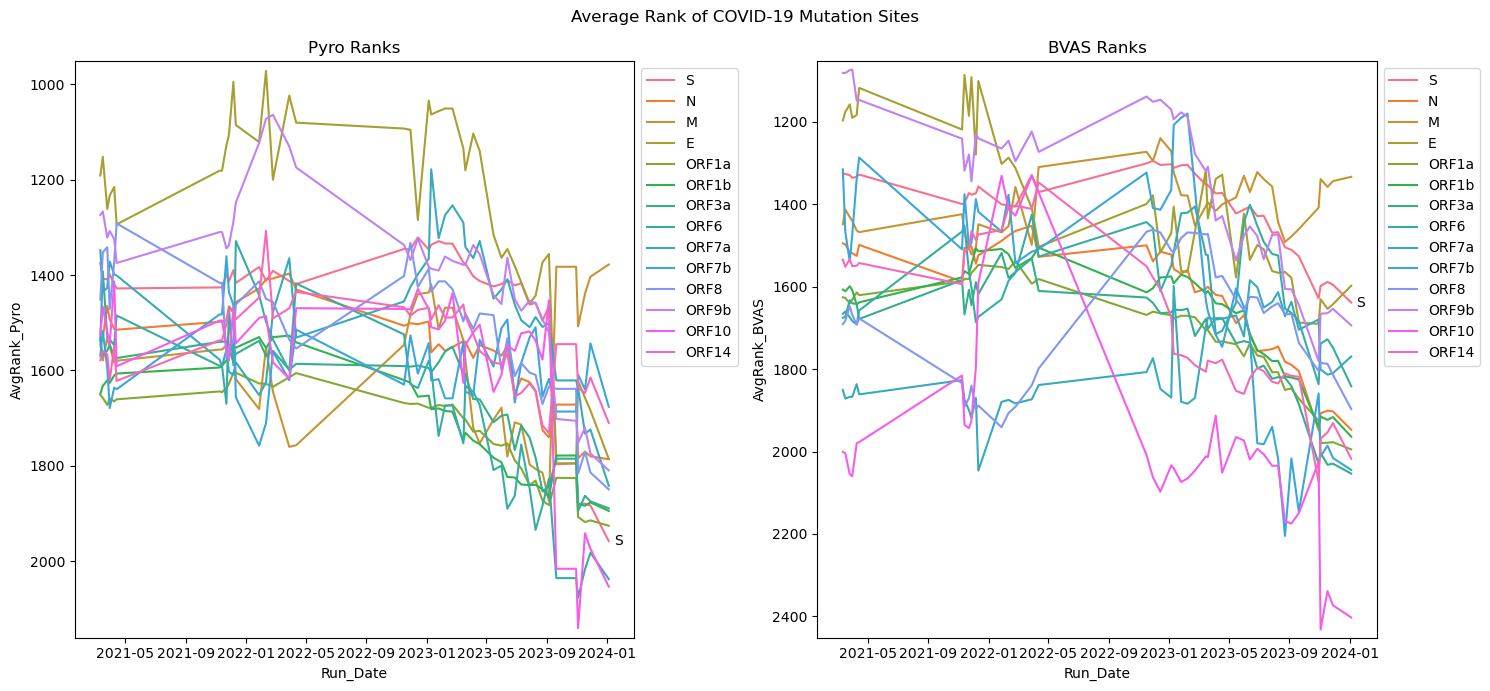

In [34]:

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.lineplot(data = combined_reduced,
                x = "Run_Date",
                y = "AvgRank_Pyro",
                hue = "Site",
                ax=ax[0])
ax[0].set_ylim([max(combined_reduced["AvgRank_Pyro"])+20, min(combined_reduced["AvgRank_Pyro"])-20])
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].set_title("Pyro Ranks")

sns.lineplot(data = combined_reduced,
                x = "Run_Date",
                y = "AvgRank_BVAS",
                hue = "Site",
                ax=ax[1])
ax[1].set_ylim([max(combined_reduced["AvgRank_BVAS"])+20, min(combined_reduced["AvgRank_BVAS"])-20])
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].set_title("BVAS Ranks")

for index, row in combined_reduced.iterrows():
    if ((row['Run_Date']==max(combined_reduced['Run_Date']))&(row['Site']=='S')):
        ax[0].annotate(f'{row["Site"]}', (row['Run_Date'], row['AvgRank_Pyro']),
                       textcoords="offset points", xytext=(10, -3), ha='right')
        ax[1].annotate(f'{row["Site"]}', (row['Run_Date'], row['AvgRank_BVAS']),
                       textcoords="offset points", xytext=(10, -3), ha='right')

plt.suptitle("Average Rank of COVID-19 Mutation Sites")
plt.tight_layout()

In [8]:
combined_hits = combined[combined["Hits"]==1].reset_index(drop=True)
combined_hits

Run_Date Site Mutation  LogR_Pyro  Growth_Pyro  Rank_Pyro  PIP_BVAS  \
0   2021-03-12    S    R346T   0.154167     1.166690        8.0  1.000000   
1   2021-03-12    S    L452M   0.164872     1.179240        6.0  1.000000   
2   2021-03-12    S    F486P   0.000214     1.000210      819.5  0.017686   
3   2021-03-17    S    R346T   0.174680     1.190870        6.0  1.000000   
4   2021-03-17    S    L452M   0.166243     1.180860        8.0  1.000000   
..         ...  ...      ...        ...          ...        ...       ...   
127 2023-11-28    S    F486P  -0.002501     0.997503     3495.0  1.000000   
128 2023-11-28    S    L452M  -0.004281     0.995728     3530.0  1.000000   
129 2024-01-04    S    R346T   0.007697     1.007730      248.0  1.000000   
130 2024-01-04    S    L452M  -0.005157     0.994856     3594.0  1.000000   
131 2024-01-04    S    F486P  -0.003764     0.996243     3568.5  1.000000   

     Beta_BVAS  Rank_BVAS  Hits  
0     0.595724          2     1  
1     0.462981          5     1  
2     0.000595        587     1  
3     0.594926          2     1  
4     0.461150          5     1  
..         ...        ...   ...  
127   0.420042          7     1  
128   0.356362         16     1  
129   0.380951          8     1  
130   0.345954         18     1  
131   0.438770          3     1  

[132 rows x 10 columns]

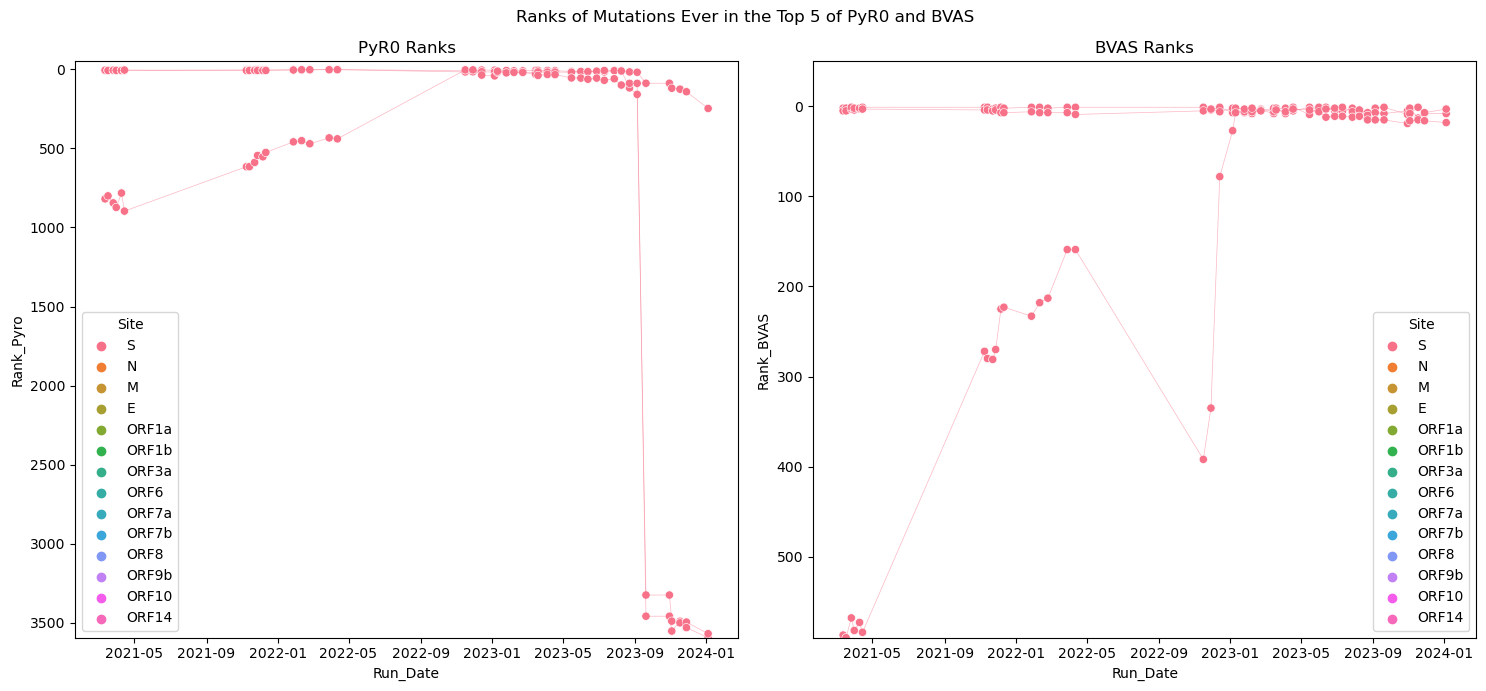

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.scatterplot(data=combined_hits,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Site",
                palette=site_palette,
                ax=ax[0])
sns.lineplot(data=combined_hits,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Mutation",
                palette=mut_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[0])
ax[0].set_ylim([max(combined_hits["Rank_Pyro"]), -50])
ax[0].set_title("PyR0 Ranks")

sns.scatterplot(data=combined_hits,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Site",
                palette=site_palette,
                ax=ax[1])
sns.lineplot(data=combined_hits,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Mutation",
                palette=mut_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[1])
ax[1].set_ylim([max(combined_hits["Rank_BVAS"]), -50])
ax[1].set_title("BVAS Ranks")

plt.suptitle("Ranks of Mutations Ever in the Top 5 of PyR0 and BVAS")
plt.tight_layout()

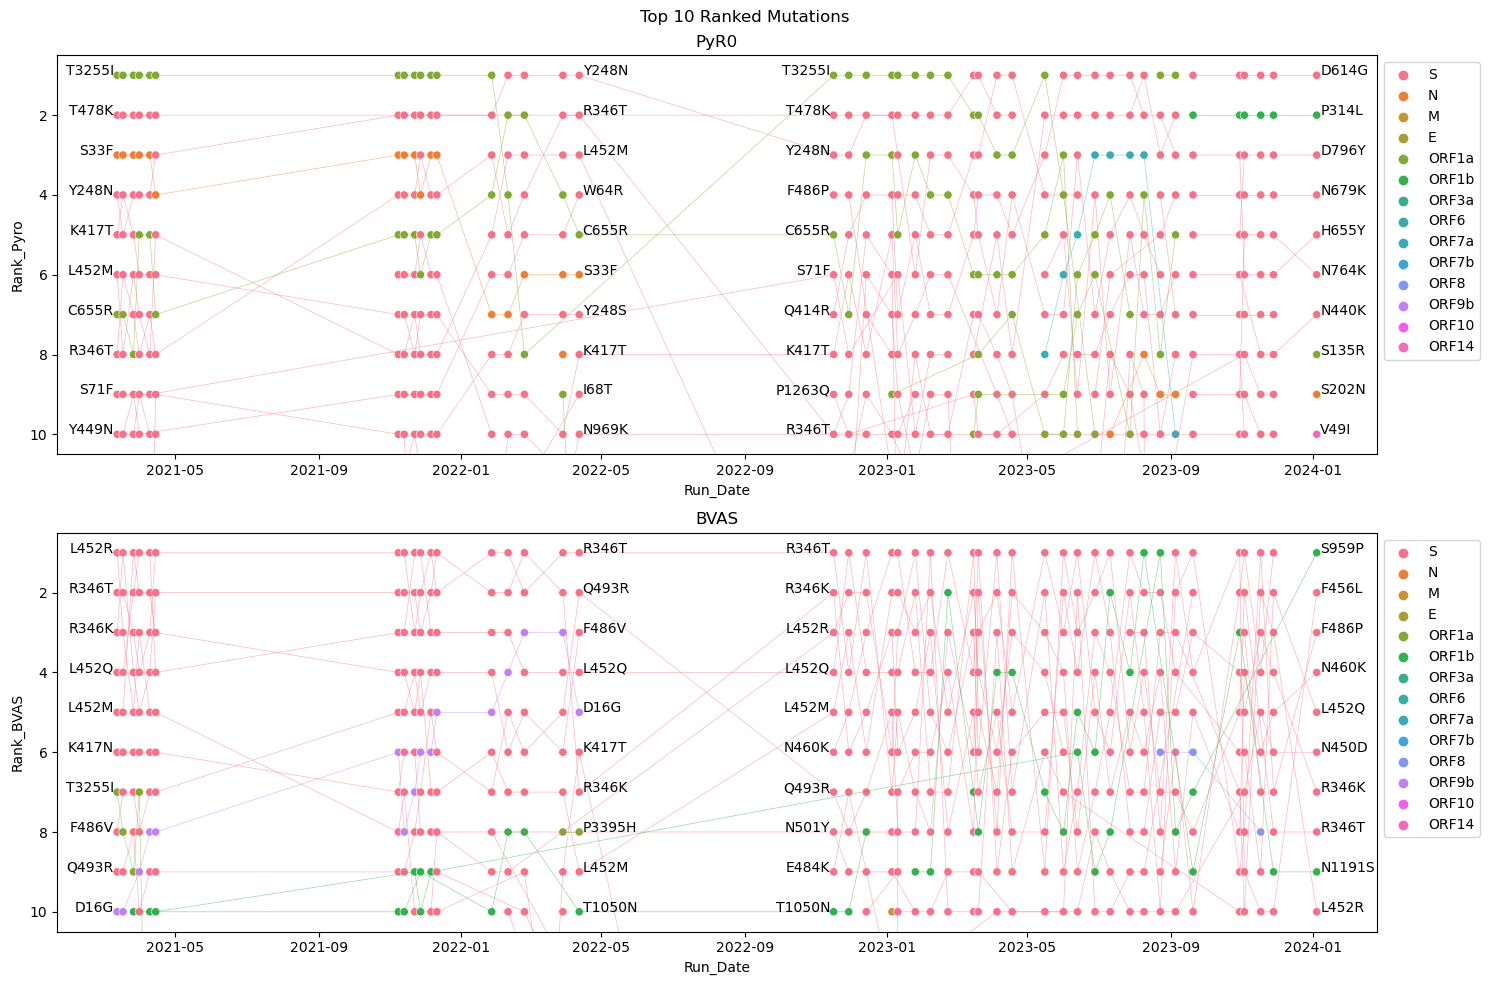

In [10]:
n = 10
combined_10 = combined[(combined["Rank_BVAS"]<=n)|(combined["Rank_Pyro"]<=n)].copy()


fig, ax = plt.subplots(nrows=2, figsize=(15,n))

sns.scatterplot(data=combined_10,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Site",
                palette=site_palette,
                ax=ax[0])
sns.lineplot(data=combined_10,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Mutation",
                palette=mut_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[0])
ax[0].set_ylim([(n+0.5), 0.5])
ax[0].set_title("PyR0")

for index, row in combined_10.iterrows():
    if (row['Run_Date']==min(combined_10['Run_Date']))|(row['Run_Date']==pd.to_datetime("2022-11-16")):
        ax[0].annotate(f'{row["Mutation"]}', (row['Run_Date'], row['Rank_Pyro']),
                    textcoords="offset points", xytext=(-2.5, 0), ha='right')
    if (row['Run_Date']==max(combined_10['Run_Date']))|(row['Run_Date']==pd.to_datetime("2022-04-12")):
        ax[0].annotate(f'{row["Mutation"]}', (row['Run_Date'], row['Rank_Pyro']),
                    textcoords="offset points", xytext=(2.5, 0), ha='left')
        
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.scatterplot(data=combined_10,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Site",
                palette=site_palette,
                ax=ax[1])
sns.lineplot(data=combined_10,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Mutation",
                palette=mut_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[1])
ax[1].set_ylim([(n+0.5), 0.5])
ax[1].set_title("BVAS")

for index, row in combined_10.iterrows():
    if (row['Run_Date']==min(combined_10['Run_Date']))|(row['Run_Date']==pd.to_datetime("2022-11-16")):
        ax[1].annotate(f'{row["Mutation"]}', (row['Run_Date'], row['Rank_BVAS']),
                    textcoords="offset points", xytext=(-2.5, 0), ha='right')
    if (row['Run_Date']==max(combined_10['Run_Date']))|(row['Run_Date']==pd.to_datetime("2022-04-12")):
        ax[1].annotate(f'{row["Mutation"]}', (row['Run_Date'], row['Rank_BVAS']),
                    textcoords="offset points", xytext=(2.5, 0), ha='left')
        
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.suptitle("Top 10 Ranked Mutations")
plt.tight_layout()


In [11]:
combined_10["Rank_BVAS"].corr(combined_10["Rank_Pyro"])

-0.09072605330328558

In [12]:
combined_hits["Rank_BVAS"].corr(combined_hits["Rank_Pyro"])

0.0896319223095423

In [13]:
combined_hits["Beta_BVAS"].corr(combined_hits["Growth_Pyro"])

0.6063171278631689

In [14]:
combined["Rank_BVAS"].corr(combined["Rank_Pyro"])

0.13603640597418204

In [15]:
combined["Beta_BVAS"].corr(combined["Growth_Pyro"])

0.4606418636748522

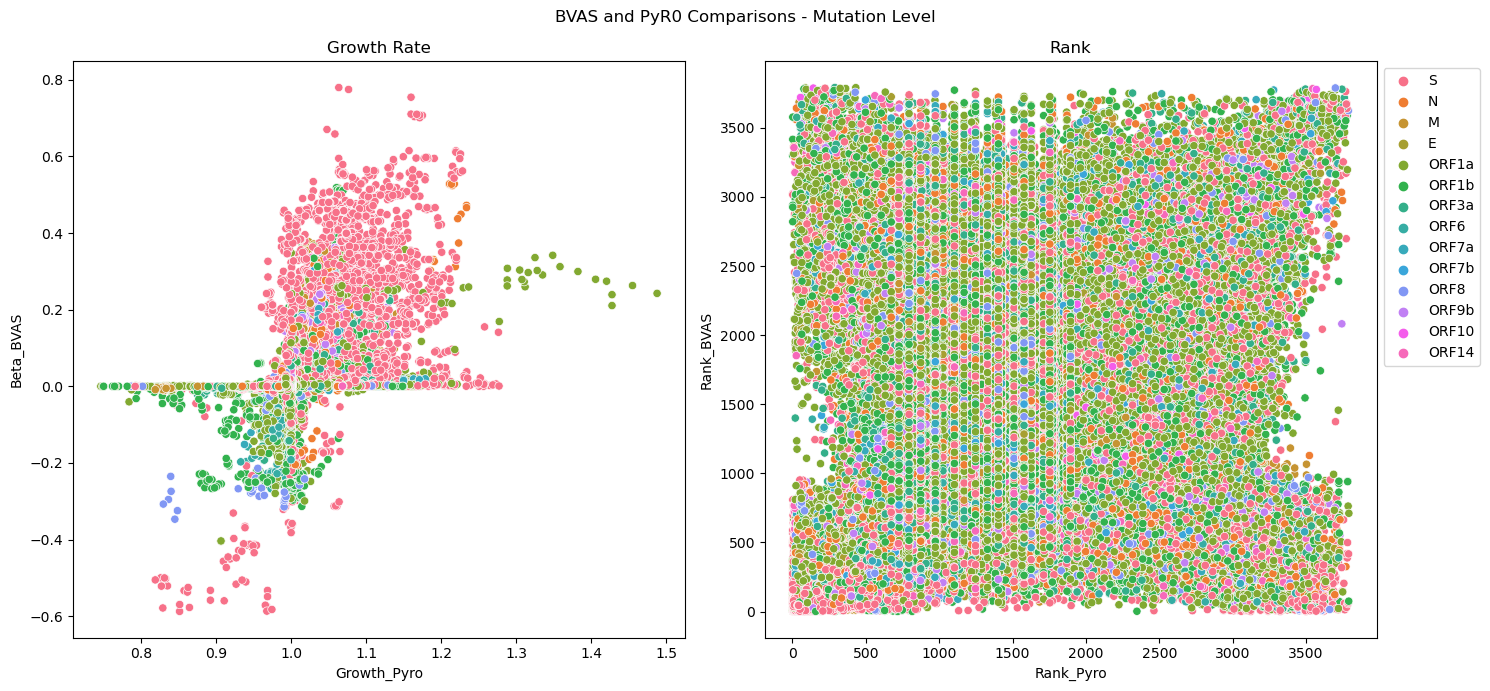

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
sns.scatterplot(data=combined,
                x="Growth_Pyro",
                y="Beta_BVAS",
                hue="Site",
                ax=ax[0],
                legend=False)
ax[0].set_title("Growth Rate")
sns.scatterplot(data=combined,
                x="Rank_Pyro",
                y="Rank_BVAS",
                hue="Site",
                ax=ax[1])
ax[1].set_title("Rank")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.suptitle("BVAS and PyR0 Comparisons - Mutation Level")
plt.tight_layout()
                